In [1]:
import numpy as np
import pandas as pd

In [2]:
from scipy.stats import zscore
import statsmodels.formula.api as smf

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [5]:
from sklearn.metrics import mean_squared_error

In [23]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from warnings import filterwarnings
filterwarnings('ignore')

In [8]:
df = pd.read_csv('clean_train_data.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,FDA15,9.30,0,0.016047,4,249.8092,9,1,0,1,3735.1380,22
1,DRC01,5.92,1,0.019278,14,48.2692,3,1,2,2,443.4228,12
2,FDN15,17.50,0,0.016760,10,141.6180,9,1,0,1,2097.2700,22
3,FDX07,19.20,1,0.000000,6,182.0950,0,1,2,0,732.3800,23
4,NCD19,8.93,0,0.000000,9,53.8614,1,0,2,1,994.7052,34


In [9]:
# dependent and independent variables

x = df.drop(['Item_Identifier','Item_Outlet_Sales'], axis=1)
y = df['Item_Outlet_Sales']

In [10]:
# train, test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [11]:
# scaled versions

x_train_sc = x_train.apply(zscore)
x_test_sc = x_test.apply(zscore)

### Linear Regression Model

In [12]:
model = LinearRegression().fit(x_train, y_train)

y_pred_train = model.predict(x_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)

y_pred_test = model.predict(x_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print('Train RMSE: {}'.format(round(train_rmse,2)))
print('Test RMSE : {}'.format(round(test_rmse,2)))

Train RMSE: 1182.35
Test RMSE : 1222.73


In [13]:
weights = model.coef_
coeff = pd.DataFrame(weights, columns=['Coefficient'], index=x_train.columns)
print(coeff)

                      Coefficient
Item_Weight             -2.552772
Item_Fat_Content        45.376462
Item_Visibility      -1295.481358
Item_Type                2.049159
Item_MRP                15.379082
Outlet_Identifier       62.803843
Outlet_Size           -353.332531
Outlet_Location_Type  -214.907653
Outlet_Type            860.424163
Outlet_Age              -1.572709


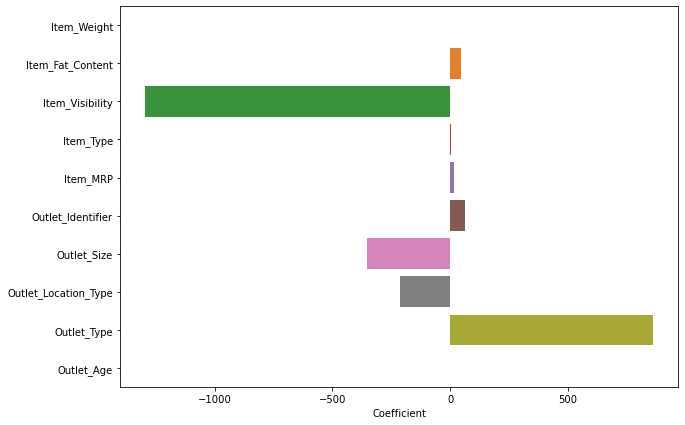

In [14]:
plt.figure(figsize=(10,7))
sns.barplot(x=coeff['Coefficient'], y=coeff.index)
plt.show()

### Cross Validation

In [59]:
# custom function for model evaluation

def evaluate_model(x,y,repeats):
    cross_validator = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=0)
    model = LinearRegression()
    scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=cross_validator, n_jobs=-1)
    return scores

In [60]:
results = []
repeats = np.arange(1,11)

for i in repeats:
    rmse = evaluate_model(x,y,i)
    results.append(rmse)

In [61]:
# to change the sign, take square root of the values

results_adj = results.copy()

for i in range(0,10):
    for j in range(0, (i+1)*10):
        value = np.sqrt(abs(results[i][j]))
        results_adj[i][j] = value

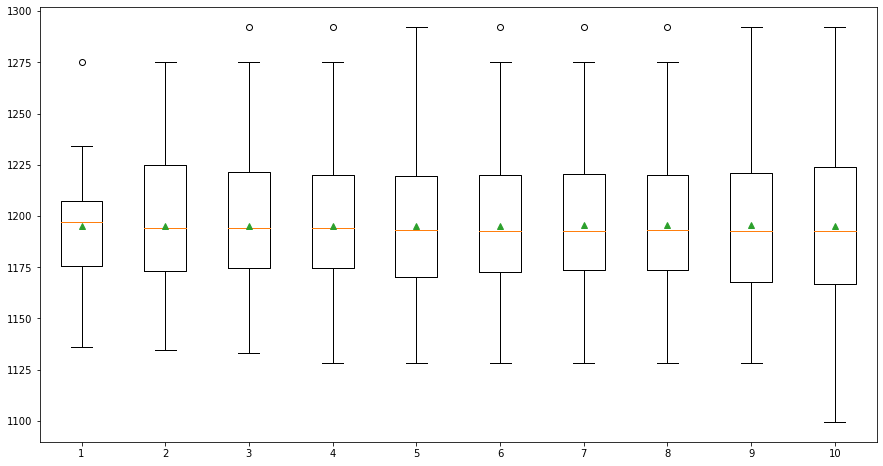

In [62]:
rcParams['figure.figsize'] = (15,8)
plt.boxplot(results_adj, labels=[str(i) for i in repeats], showmeans=True)
plt.show()

In [63]:
# repeats=3 (rmse of the model for complete training data)

cross_validator = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)
model = LinearRegression()
scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=cross_validator, n_jobs=-1)
final_score = np.round(np.sqrt(abs(scores.mean())),2)
print(final_score)

1195.79


### Decision Tree Regressor

In [64]:
# raw decision tree model
model = DecisionTreeRegressor(random_state=0).fit(x_train,y_train)

y_pred_train = model.predict(x_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)

y_pred_test = model.predict(x_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print('Train RMSE: {}'.format(round(train_rmse,2)))
print('Test RMSE : {}'.format(round(test_rmse,2)))

Train RMSE: 0.0
Test RMSE : 1567.23


In [65]:
# grid search
parameters = {'max_depth': [15,20,25],
              'min_samples_leaf': [20,25,30],
              'min_samples_split': [45,60,75]}

model = DecisionTreeRegressor(random_state=0)
grid = GridSearchCV(estimator=model, param_grid=parameters, cv=5, n_jobs=-1).fit(x_train,y_train)
print(grid.best_params_)

{'max_depth': 15, 'min_samples_leaf': 25, 'min_samples_split': 75}


In [66]:
model = grid.best_estimator_.fit(x_train,y_train)

y_pred_train = model.predict(x_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)

y_pred_test = model.predict(x_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print('Train RMSE: {}'.format(round(train_rmse,2)))
print('Test RMSE : {}'.format(round(test_rmse,2)))

Train RMSE: 1008.0
Test RMSE : 1151.75


### Cross Validation

In [67]:
# custom function for model evaluation

def evaluate_model(x,y,repeats):
    cross_validator = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=0)
    model = grid.best_estimator_
    scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=cross_validator, n_jobs=-1)
    return scores

In [68]:
results = []
repeats = np.arange(1,11)

for i in repeats:
    rmse = evaluate_model(x,y,i)
    results.append(rmse)

In [69]:
# to change the sign, take square root of the values

results_adj = results.copy()

for i in range(0,10):
    for j in range(0, (i+1)*10):
        value = np.sqrt(abs(results[i][j]))
        results_adj[i][j] = value

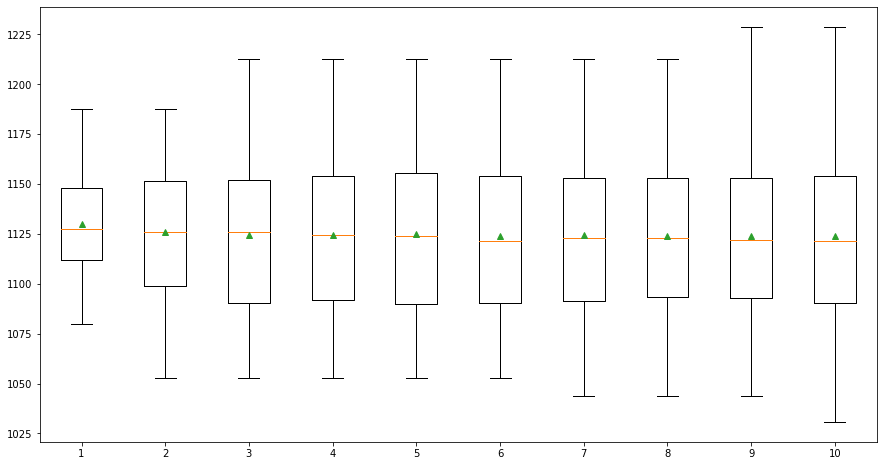

In [70]:
rcParams['figure.figsize'] = (15,8)
plt.boxplot(results_adj, labels=[str(i) for i in repeats], showmeans=True)
plt.show()

In [71]:
# repeats=4 (rmse of the model for complete training data)

cross_validator = RepeatedKFold(n_splits=10, n_repeats=4, random_state=0)
model = grid.best_estimator_
scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=cross_validator, n_jobs=-1)
final_score = np.round(np.sqrt(abs(scores.mean())),2)
print(final_score)

1125.17


### Random Forest Regressor

In [72]:
# raw random forest model
model = RandomForestRegressor(n_estimators=100, max_features=7, random_state=0).fit(x_train,y_train)

y_pred_train = model.predict(x_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)

y_pred_test = model.predict(x_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print('Train RMSE: {}'.format(round(train_rmse,2)))
print('Test RMSE : {}'.format(round(test_rmse,2)))

Train RMSE: 420.13
Test RMSE : 1154.95


In [73]:
# grid search
parameters = {'max_depth': [15,20],
              'max_features': [6,7],
              'min_samples_leaf': [20,25],
              'min_samples_split': [60,75],
              'n_estimators': [150,200]}

model = RandomForestRegressor(random_state=0)
grid = GridSearchCV(estimator=model, param_grid=parameters, cv=5, n_jobs=-1).fit(x_train,y_train)
print(grid.best_params_)

{'max_depth': 15, 'max_features': 6, 'min_samples_leaf': 25, 'min_samples_split': 60, 'n_estimators': 200}


In [74]:
model = grid.best_estimator_.fit(x_train,y_train)

y_pred_train = model.predict(x_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)

y_pred_test = model.predict(x_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print('Train RMSE: {}'.format(round(train_rmse,2)))
print('Test RMSE : {}'.format(round(test_rmse,2)))

Train RMSE: 1005.56
Test RMSE : 1109.04


### Cross Validation

In [76]:
results = []
repeats = np.arange(1,11)

for i in repeats:
    rmse = evaluate_model(x,y,i)
    results.append(rmse)

In [77]:
# to change the sign, take square root of the values

results_adj = results.copy()

for i in range(0,10):
    for j in range(0, (i+1)*10):
        value = np.sqrt(abs(results[i][j]))
        results_adj[i][j] = value

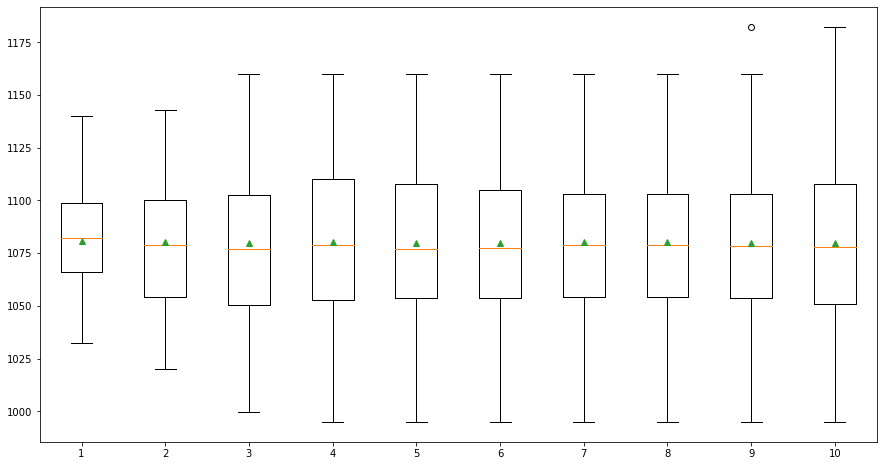

In [78]:
rcParams['figure.figsize'] = (15,8)
plt.boxplot(results_adj, labels=[str(i) for i in repeats], showmeans=True)
plt.show()

In [83]:
# repeats=9 (rmse of the model for complete training data)

cross_validator = RepeatedKFold(n_splits=10, n_repeats=9, random_state=0)
model = grid.best_estimator_
scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=cross_validator, n_jobs=-1)
final_score = np.round(np.sqrt(abs(scores.mean())),2)
print(final_score)

1080.61


### MLP Regressor

In [84]:
# raw ann model
model = MLPRegressor(max_iter=1000,random_state=0).fit(x_train_sc,y_train)

y_pred_train = model.predict(x_train_sc)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)

y_pred_test = model.predict(x_test_sc)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print('Train RMSE: {}'.format(round(train_rmse,2)))
print('Test RMSE : {}'.format(round(test_rmse,2)))

Train RMSE: 1067.58
Test RMSE : 1106.98


In [85]:
# grid search
parameters = {'hidden_layer_sizes':[(500),(100,100)],
              'activation': ["tanh", "relu"], 
              'solver': ["sgd", "adam"]}

model = MLPRegressor(max_iter=1000, random_state=0)
grid = GridSearchCV(estimator=model, param_grid=parameters, cv=5, n_jobs=-1).fit(x_train_sc,y_train)
print(grid.best_params_)

{'activation': 'relu', 'hidden_layer_sizes': 500, 'solver': 'adam'}


In [86]:
model = grid.best_estimator_.fit(x_train_sc,y_train)

y_pred_train = model.predict(x_train_sc)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)

y_pred_test = model.predict(x_test_sc)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print('Train RMSE: {}'.format(round(train_rmse,2)))
print('Test RMSE : {}'.format(round(test_rmse,2)))

Train RMSE: 1050.63
Test RMSE : 1099.44


### Cross Validation

In [87]:
# scaled version
x_sc = x.apply(zscore)

In [89]:
# repeats=2 (rmse of the model for complete training data)

cross_validator = RepeatedKFold(n_splits=10, n_repeats=2, random_state=0)
model = grid.best_estimator_
scores = cross_val_score(model, x_sc, y, scoring='neg_mean_squared_error', cv=cross_validator, n_jobs=-1)
final_score = np.round(np.sqrt(abs(scores.mean())),2)
print(final_score)

1077.14


### Model Comparison

**Train and Test RMSE**

In [91]:
data = {'Train RMSE': [1182.35, 1008.00, 1005.56, 1050.63],
        'Test RMSE':[1222.73, 1151.75, 1109.04, 1099.44],
        'Final RMSE':[1195.79, 1125.17, 1080.61, 1077.14]}
index = ['Linear Regressor','Decision Tree Regressor', 'Random Forest Regressor', 'MLP Regressor']
print(pd.DataFrame(data, index=index))

                         Train RMSE  Test RMSE  Final RMSE
Linear Regressor            1182.35    1222.73     1195.79
Decision Tree Regressor     1008.00    1151.75     1125.17
Random Forest Regressor     1005.56    1109.04     1080.61
MLP Regressor               1050.63    1099.44     1077.14
